In [1]:
# Importing Libraries and Modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
import absl.logging

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

In [2]:
# Loading and Preparing the Dataset
import glob
train = glob.glob("Alzheimer_s Dataset/train/**/*.jpg")
test = glob.glob("Alzheimer_s Dataset/test/**/*.jpg")
print("There is {} images in the training dataset".format(len(train)))
print("There is {} images in the test dataset".format(len(test)))

There is 5121 images in the training dataset
There is 1279 images in the test dataset


In [3]:
import os
main_folder = 'Alzheimer_s Dataset'
subfolders = ['train', 'test']

for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)
    class_names = os.listdir(subfolder_path)
    
    print(f"\nNumber of images in {subfolder} folder:")
    
    for class_name in class_names:
        class_folder = os.path.join(subfolder_path, class_name)
        num_images = len(os.listdir(class_folder))
        print(f"Class {class_name}: {num_images} images")


Number of images in train folder:
Class MildDemented: 717 images
Class ModerateDemented: 52 images
Class NonDemented: 2560 images
Class VeryMildDemented: 1792 images

Number of images in test folder:
Class MildDemented: 179 images
Class ModerateDemented: 12 images
Class NonDemented: 640 images
Class VeryMildDemented: 448 images


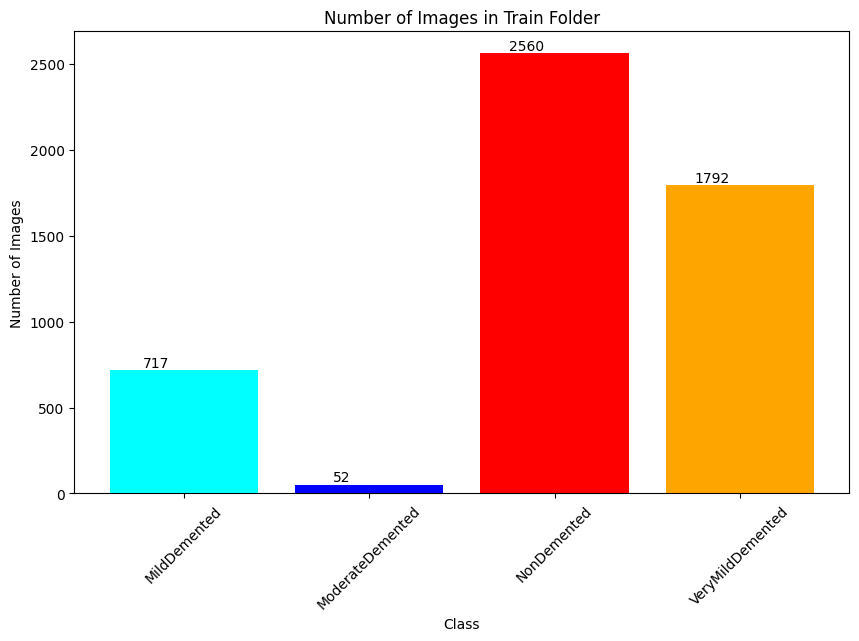

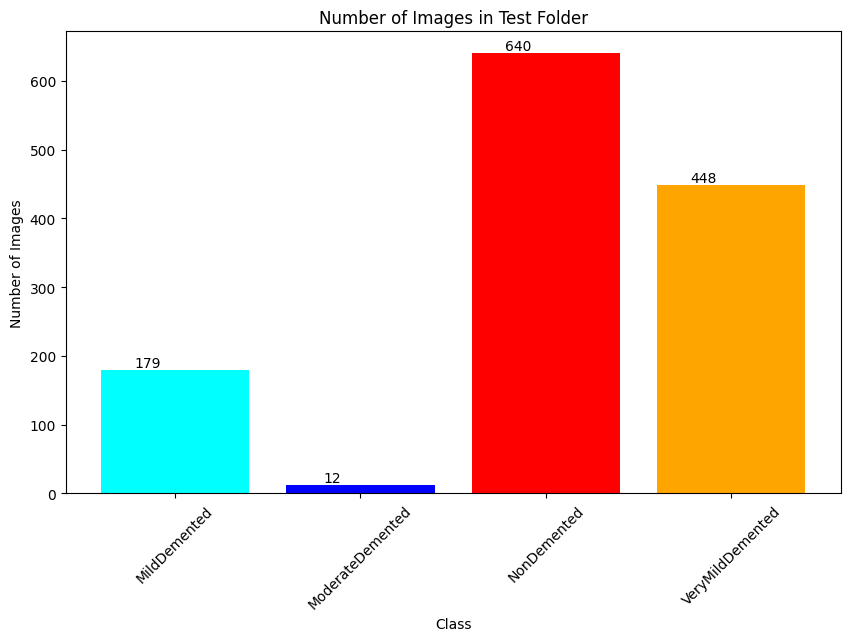

In [4]:
# Visualize the dataset
for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)
    class_names = os.listdir(subfolder_path)
    class_counts = []
    for class_name in class_names:
        class_folder = os.path.join(subfolder_path, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts.append(num_images)
    
    plt.figure(figsize=(10, 6))
    c = ['cyan', 'blue', 'red', 'orange']
    bars = plt.bar(class_names, class_counts, color=c)
    plt.title(f"Number of Images in {subfolder.capitalize()} Folder")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    
    for bar, count in zip(bars, class_counts):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.1, str(count), ha='center', va='bottom')
    
    plt.show()

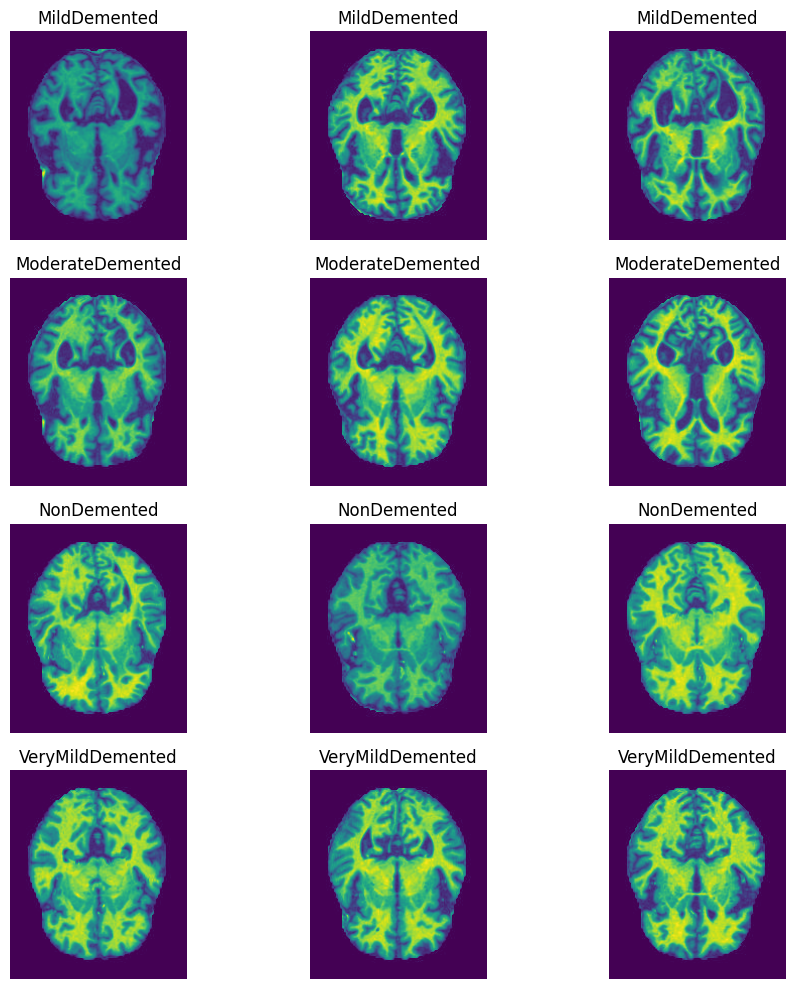

In [5]:
# Show some samples from test dataset
train_folder = 'Alzheimer_s Dataset/train'
class_names = os.listdir(train_folder)
num_images_per_class = 3

plt.figure(figsize=(10, 10))

for class_name in class_names:
    class_folder = os.path.join(train_folder, class_name)
    image_files = os.listdir(class_folder)[:num_images_per_class]
    
    for image_file in image_files:
        image_path = os.path.join(class_folder, image_file)
        image = mpimg.imread(image_path)
        
        plt.subplot(len(class_names), num_images_per_class, class_names.index(class_name) * num_images_per_class + image_files.index(image_file) + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Initialize the Model Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 176
CHANNELS = 3
EPOCHS = 50

In [7]:
# Generate train and test dataset for model
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [8]:
# Load the train dataset
train_ds  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [9]:
# Data Augmentation
class_indices = train_ds.class_indices
oversampled_data = {
    class_index: np.where(train_ds.classes == class_index)[0]
    for class_index in class_indices.values()
}

class_counts = np.unique(train_ds.classes, return_counts=True)[1]
max_class_count = max(class_counts)

In [10]:
def oversample_indices():
    indices = []
    for class_index, samples in oversampled_data.items():
        oversample_size = max_class_count - len(samples)
        oversampled = np.random.choice(samples, size=oversample_size, replace=True)
        indices.extend(samples)  
        indices.extend(oversampled)  
    np.random.shuffle(indices)  
    return indices

In [11]:
# Generate oversampled indices
oversampled_indices = oversample_indices()
oversampled_generator = tf.keras.utils.Sequence()

In [12]:
class OversampledGenerator(tf.keras.utils.Sequence):
    def __init__(self, datagen, indices, batch_size, target_size):
        self.datagen = datagen
        self.indices = indices
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_samples = len(indices)
    
    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []
        for i in batch_indices:
            img, label = train_ds[i]
            images.append(img)
            labels.append(label)
        return np.array(images), np.array(labels)

In [13]:
# Instantiate the generator
oversampled_train_ds = OversampledGenerator(
    train_datagen, oversampled_indices, batch_size=32, target_size = (IMAGE_SIZE, IMAGE_SIZE)
)

In [14]:
# Load the validation and test dataset
valid_ds = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

test_ds = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                  target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [15]:
len(train_ds), len(oversampled_train_ds)

(129, 256)

In [16]:
len(valid_ds), len(test_ds)

(32, 40)

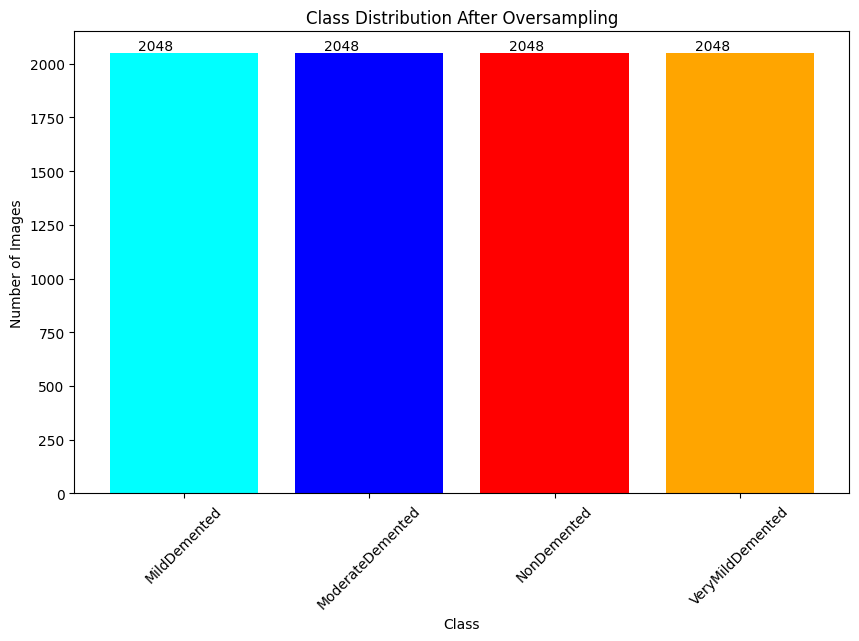

In [17]:
# Retrieve class names from the original dataset
class_indices = train_ds.class_indices  # Ensure this is a dictionary
class_names = list(class_indices.keys())  # Extract class names

# Calculate class counts for oversampled data
oversampled_class_counts = [
    len([i for i in oversampled_indices if train_ds.classes[i] == class_index])
    for class_index in range(len(class_names))
]

# Plot the class distribution after oversampling
plt.figure(figsize=(10, 6))
colors = ['cyan', 'blue', 'red', 'orange']
bars = plt.bar(class_names, oversampled_class_counts, color=colors)
plt.title("Class Distribution After Oversampling")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

# Annotate the bars with counts
for bar, count in zip(bars, oversampled_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.1, 
             str(count), ha='center', va='bottom', fontsize=10)

plt.show()

In [18]:
# CNN model
def conv_block(filters, act='relu'): 
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(MaxPool2D())
    return block

def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(Dropout(dropout_rate))
    return block

def construct_model(input_shape, n_classes, act='relu'):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        Flatten(),
        dense_block(128, 0.5),
        Dense(n_classes, activation='softmax')        
    ], name="cnn_model")

    return model

In [36]:
# Define Custom Callback
class MyCallback(Callback):
    def __init__(self, patience=10, min_delta=0.001, reduce_lr_factor=0.5, reduce_lr_patience=2):
        super(MyCallback, self).__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.reduce_lr_factor = reduce_lr_factor
        self.reduce_lr_patience = reduce_lr_patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        current_val_accuracy = logs.get('val_acc')

        if current_val_loss is not None:
            if current_val_loss < self.best_val_loss - self.min_delta:
                self.best_val_loss = current_val_loss
                self.wait = 0
            else:
                self.wait += 1

            if self.wait >= self.patience:
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                self.model.stop_training = True

        if current_val_loss and self.wait >= self.reduce_lr_patience:
            old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            new_lr = old_lr * self.reduce_lr_factor
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"Reducing learning rate to {new_lr} at epoch {epoch + 1}")

        if current_val_accuracy is not None and current_val_loss is not None:
            print(f"Epoch {epoch + 1}: Validation Accuracy: {current_val_accuracy:.4f}, Validation Loss: {current_val_loss:.4f}")
        else:
            print(f"Epoch {epoch + 1}: Validation data not available")


In [37]:
# Constract and Compile the Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = construct_model(input_shape, n_classes)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')
          ]
my_callback = MyCallback(patience=10, min_delta=0.001, reduce_lr_factor=0.5, reduce_lr_patience=2)
CALLBACKS = [my_callback]

model.build(input_shape=input_shape) 
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 176, 176, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 sequential_12 (Sequential)  (None, 44, 44, 32)        4640      
                                                                 
 sequential_13 (Sequential)  (None, 22, 22, 64)        18496     
                                                                 
 flatten_4 (Flatten)         (None, 30976)             0         
                                                                 
 sequential_14 (Sequential)  (None, 128)               3965056   
                                                         

In [38]:
# Train the model
history = model.fit(train_ds, validation_data=valid_ds, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
129/129 [==============================] - 245s 2s/step - loss: 1.1198 - acc: 0.4739 - auc: 0.7671 - val_loss: 1.0268 - val_acc: 0.5582 - val_auc: 0.8091
Epoch 2/50
129/129 [==============================] - 188s 1s/step - loss: 1.0065 - acc: 0.5059 - auc: 0.8039 - val_loss: 1.0296 - val_acc: 0.4897 - val_auc: 0.7752
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 0.9556 - acc: 0.5344 - auc: 0.8240Reducing learning rate to 0.0005000000237487257 at epoch 3
Epoch 3: Validation Accuracy: 0.4809, Validation Loss: 1.0672
129/129 [==============================] - 188s 1s/step - loss: 0.9556 - acc: 0.5344 - auc: 0.8240 - val_loss: 1.0672 - val_acc: 0.4809 - val_auc: 0.7501
Epoch 4/50
129/129 [==============================] - 140s 1s/step - loss: 0.9377 - acc: 0.5483 - auc: 0.8318 - val_loss: 0.9887 - val_acc: 0.5220 - val_auc: 0.7983
Epoch 5/50
129/129 [==============================] - 134s 1s/step - loss: 0.9234 - acc: 0.5464 - auc: 0.8355 - val_loss: 0.96

In [39]:
# Evaluate the model
scores = model.evaluate(test_ds)
scores

40/40 [==============================] - 11s 274ms/step - loss: 0.9291 - acc: 0.5520 - auc: 0.8334


[0.9291238188743591, 0.551993727684021, 0.833372175693512]

In [43]:
history.history.keys()

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])

In [41]:
# Plotting the Accuracy and Loss Curves
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

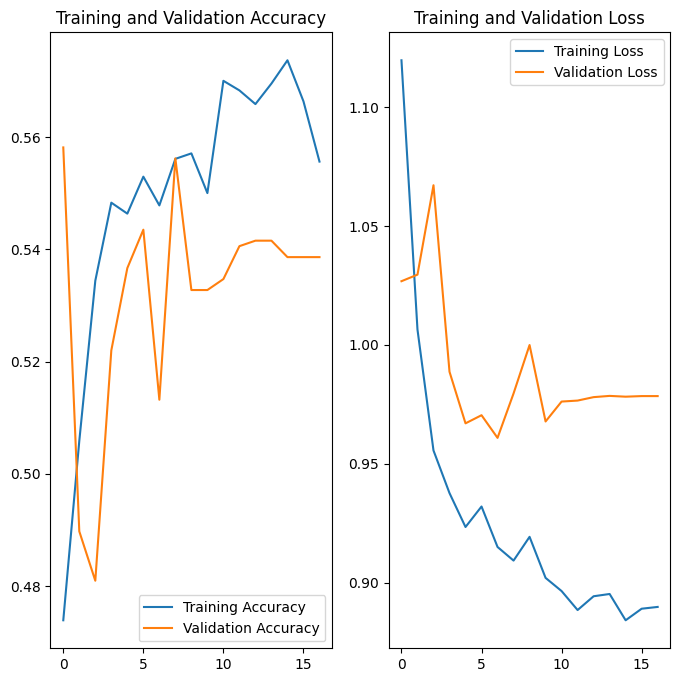

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict:
Actual label: MildDemented
1/1 [==============================] - 1s 872ms/step
Predicted label: NonDemented


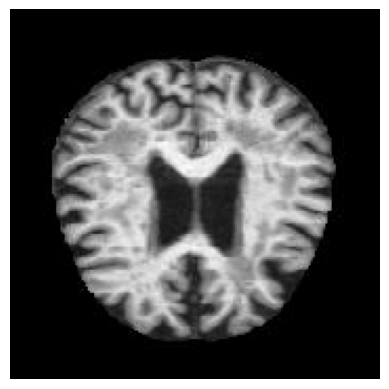

In [47]:
# Run prediction on a sample image
class_names = list(test_ds.class_indices.keys())

images_batch, labels_batch = next(test_ds)

first_image = (images_batch[0] * 255).astype('uint8') 
first_label = labels_batch[0]

print("First image to predict:")
plt.imshow(first_image)
plt.axis("off")

actual_label_index = np.argmax(first_label)
print("Actual label:", class_names[actual_label_index])

batch_prediction = model.predict(images_batch)
predicted_label_index = np.argmax(batch_prediction[0])
print("Predicted label:", class_names[predicted_label_index])

In [48]:
def predict(model, image):
    image_array = np.expand_dims(image, axis=0)
    predictions = model.predict(image_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100
    return predicted_class, confidence

1/1 [==============================] - 0s 62ms/step


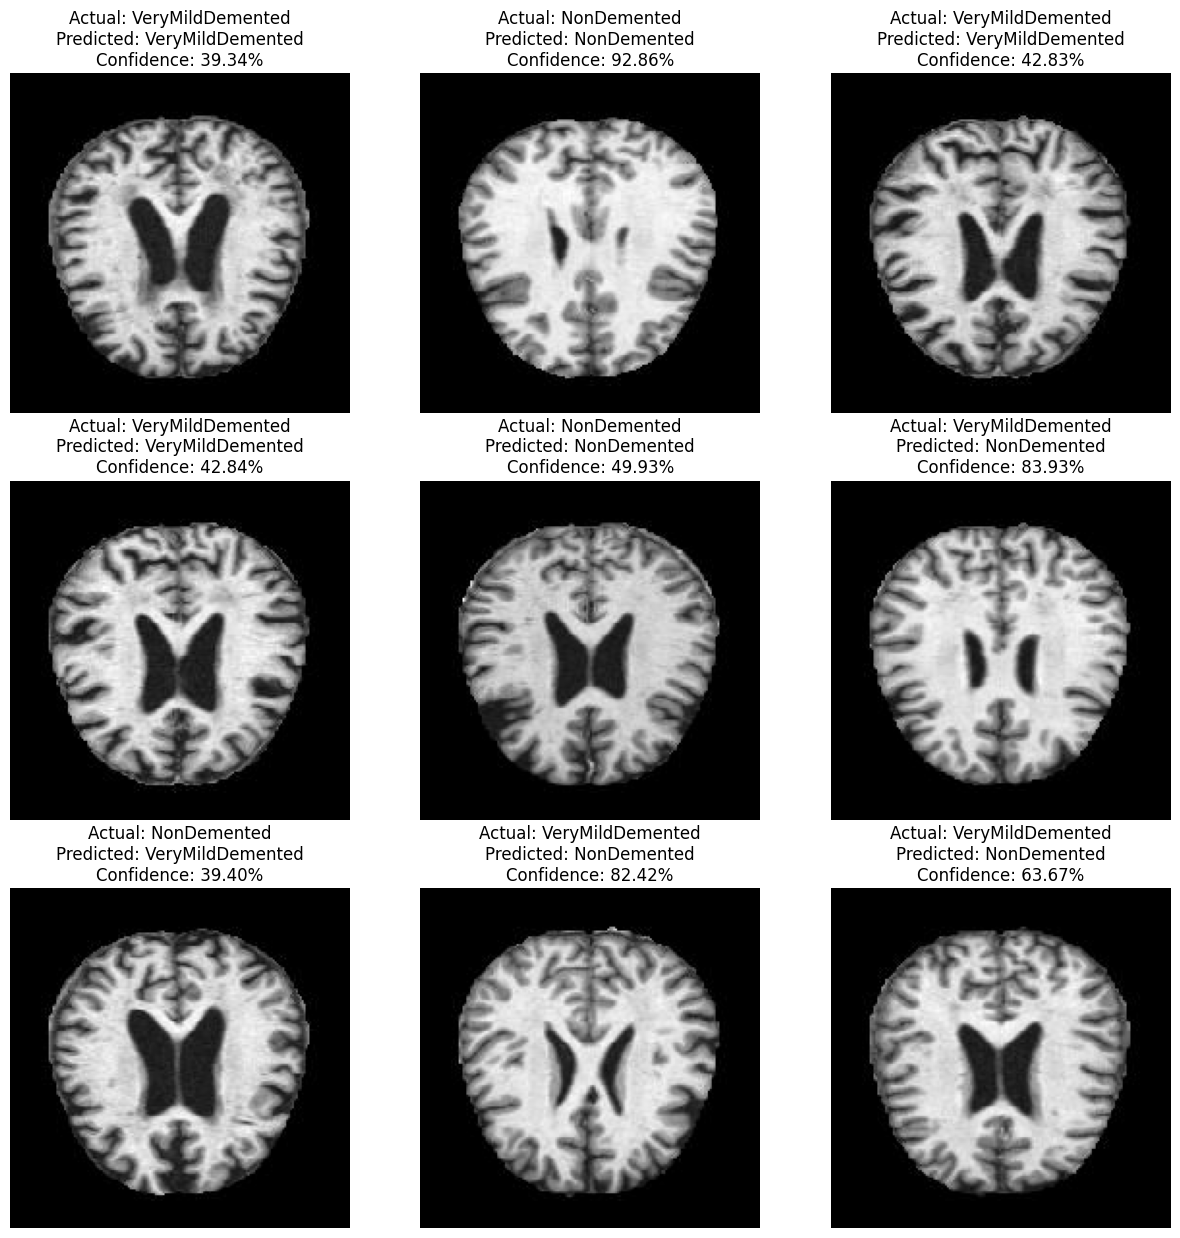

In [49]:
# Visualize the predicted and actual result 
plt.figure(figsize=(15, 15))
images, labels = next(test_ds)

for i in range(9):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))  
    predicted_class, confidence = predict(model, images[i])
    actual_class_index = np.argmax(labels[i])
    actual_class = class_names[actual_class_index]
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis("off")

plt.show()

In [50]:
# Saving the Model
model_version=max([int(i) for i in os.listdir("Models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/3\assets


INFO:tensorflow:Assets written to: models/3\assets


In [51]:
os.listdir("Models")

['1', '2', '3']

In [52]:
# Load the model
l_m = load_model(f"models/3")
l_m.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 176, 176, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 sequential_12 (Sequential)  (None, None, None, 32)    4640      
                                                                 
 sequential_13 (Sequential)  (None, None, None, 64)    18496     
                                                                 
 flatten_4 (Flatten)         (None, 30976)             0         
                                                                 
 sequential_14 (Sequential)  (None, 128)               3965056   
                                                         

In [54]:
test_ds.reset()
y_true = []
y_pred = []

for batch in test_ds:
    x, y = batch
    y_true.extend(np.argmax(y, axis=1))
    preds = l_m.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= test_ds.samples:
        break

1/1 [==============================] - 0s 448ms/step


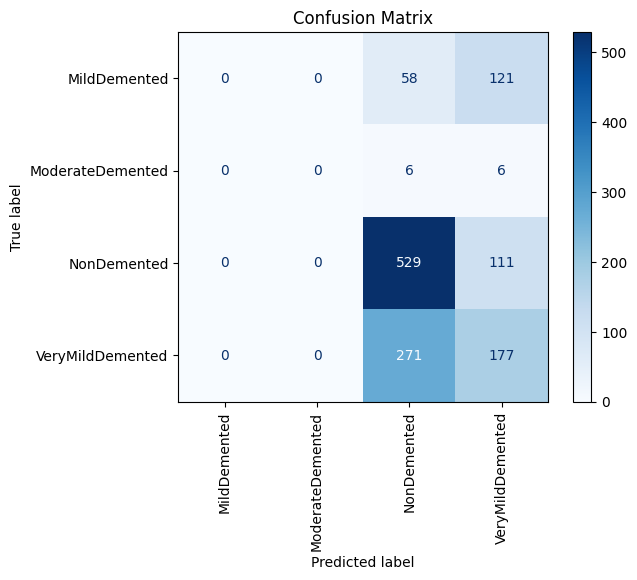

In [55]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Classification Report
clr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                   precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.61      0.83      0.70       640
VeryMildDemented       0.43      0.40      0.41       448

        accuracy                           0.55      1279
       macro avg       0.26      0.31      0.28      1279
    weighted avg       0.46      0.55      0.50      1279



C:\Programs\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Programs\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Programs\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
